In [1]:
import os
from scipy import io
from scipy import optimize as op
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression as LR

In [2]:
data = io.loadmat("ex5data1.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'Xtest', 'ytest', 'Xval', 'yval'])

In [3]:
#Training data set
X = data["X"]
XX = np.c_[np.ones((X.shape[0],1)), X]
Y = data["y"]

#Cross Validation dataset
Xval = data["Xval"]
XXval = np.c_[np.ones((Xval.shape[0],1)), Xval]
Yval = data["yval"]

#Test data set
Xtest = data["Xtest"]
Ytest = data["ytest"]
XXtest = np.c_[np.ones((Xtest.shape[0],1)), Xtest]

(array([-50.05882945]), array([40.49218733]))

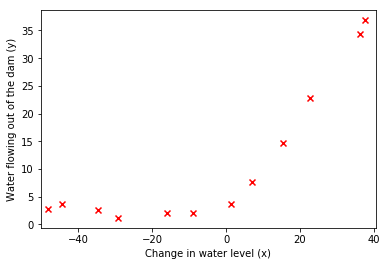

In [4]:
plt.scatter(X, Y, marker="x", c="r" )
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.xlim(min(X)-2,max(X)+3, 10)

### Regularized Linear Regression Cost Funtion

In [5]:
def linearRegCostFunction(xx, y, theta, reg):
    m,n = xx.shape
    theta = np.reshape(theta, (n,1))
    h = xx.dot(theta)
    J = (np.sum(np.square(h-y)) + reg*(np.sum(np.square(theta[1:]))))/(2*m)
    
    grad = (xx.T.dot(h-y) + reg*np.r_[[[0]],theta[1:].reshape(-1,1)])/m
    return (J, np.ndarray.flatten(grad))

In [6]:
theta = np.ones((1,2))
cost, grad = linearRegCostFunction(XX, Y, theta, 1)
print("At Reg parameter (lambda = 1) and theta = [1,1] \nCost is: ", cost, "\nGradient is: ", grad)

At Reg parameter (lambda = 1) and theta = [1,1] 
Cost is:  303.9931922202643 
Gradient is:  [-15.30301567 598.25074417]


In [7]:
def trainLinearReg(xx,y,reg=0):   #taking reg=0 as theta is small so no meaning of reg
    m,n = xx.shape
    initial_theta = np.zeros((n,1), dtype=float)
    #short hand cost funtion (takes one variable) to use inside this function
    CostFunc = lambda p: linearRegCostFunction(xx, y, p, reg)
    res = op.minimize(CostFunc, initial_theta, method=None, jac=True, options={"maxIter": 200}) 
    return res

In [8]:
res = trainLinearReg(XX,Y,reg=0)
optimized_theta = res.x
print("Optimal theta is:", optimized_theta)
J, _ = linearRegCostFunction(XX, Y, optimized_theta, 0)
print("\nCost at optimal theta will be:", J)

Optimal theta is: [13.08790351  0.36777923]

Cost at optimal theta will be: 22.373906495108912


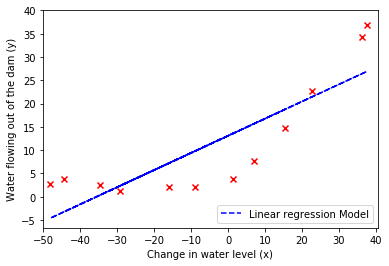

In [9]:
plt.scatter(X, Y, marker="x", c="r" )
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.xlim(min(X)-2,max(X)+3, 10)

#Linear regression model plot
lin_reg = LR()
lin_reg.fit(X, Y.ravel())
plt.plot(X, lin_reg.intercept_+X.dot(lin_reg.coef_) , linestyle='dashed', label='Linear regression Model', c="b")
plt.legend(loc = 'lower right')
plt.xticks(np.arange(-50,41,10))
plt.yticks(np.arange(-5,41,5))
plt.show()

### Learning Curves

In [10]:
def learningCurve(xx,y,xxval,yval,reg):
    #taking subset of training set to get the training error
    m,n = xx.shape
    error_train = np.zeros((m,1))     #J_train
    error_val = np.zeros((m,1))       #J_cv
    for i in range(m):
        res = trainLinearReg(xx[0:i+1],y[0:i+1],reg=0)
        theta = res.x
        error_train[i] = linearRegCostFunction(xx[0:i+1], y[0:i+1], theta, reg=0)[0]
        error_val[i] = linearRegCostFunction(xxval, yval, theta, reg=0)[0]
    return (error_train, error_val)

In [11]:
J_train, J_cv = learningCurve(XX,Y,XXval,Yval,reg=0)

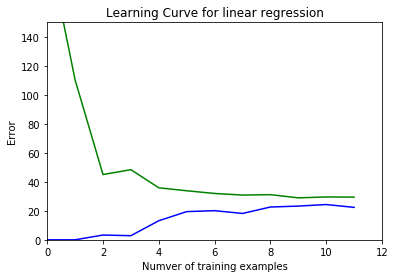

In [12]:
m = len(J_train)
plt.plot(range(m), J_train, c="b", label = "Train")
plt.plot(range(m), J_cv, c="g", label = "Cross Validation")
plt.title("Learning Curve for linear regression")
plt.xlabel("Numver of training examples")
plt.ylabel("Error")
plt.xlim(0,12)
plt.ylim(0,150)
plt.show()

### Polynomial Regression

###### The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias). so we will address this problem by adding more features

In [13]:
#we can also use direct PolynomialFeature funtion import from sklearn.preprocessing
def polyFeatures(x,d):     #d = degree of polynomial
    m,n = x.shape
    x_poly = np.zeros((m,d))
    for i in range(m):
        for j in range(d):
            x_poly[i][j] = np.power(x.ravel()[i],j+1)
    return (x_poly)    

In [14]:
x_5 = polyFeatures(X,5)   #so here our hypothesis h(x) is 5th order polynomial

In [15]:
def featureNormalize(arr): #passing an array
    m,n = arr.shape
    arr_norm = np.zeros((arr.shape))
#     y_norm = np.zeros((m,1))
    mu = np.zeros((1,n))         #if you need y replace n with n+1
    std = np.zeros((1,n))
    for i in range(n):
        mu[:,i] = np.mean(arr[:,i])
        std[:,i] = np.std(arr[:,i])
        arr_norm[:,i] = (arr[:,i]-mu[:,i])/std[:,i] 
#     mu[:,n] = np.mean(y)
#     std[:,n] = np.std(y)
#     y_norm = (y - mu[:,n])/std[:,n]
    return(arr_norm, mu, std)

In [16]:
x_5, mu, std= featureNormalize(x_5)

In [17]:
#taking 8 degree polynomial and making training/val/testing set
x_poly = polyFeatures(X,d=8)
x_poly = featureNormalize(x_poly)[0]
xx_poly = np.c_[np.ones((x_poly.shape[0],1)), x_poly]

x_poly_cv = polyFeatures(Xval,d=8)
x_poly_cv = featureNormalize(x_poly_cv)[0]
xx_poly_cv = np.c_[np.ones((x_poly_cv.shape[0],1)), x_poly_cv]

x_poly_test = polyFeatures(Xtest,d=8)
xx_poly_test = featureNormalize(x_poly_test)[0]
xx_poly_test = np.c_[np.ones((x_poly_test.shape[0],1)), x_poly_test]


In [18]:
# plotting range slightly bigger than x_min and x_max
def plotFit(x, min_x, max_x, theta, d):
    x = np.arange(min_x - 5, max_x +7, .05).reshape(-1, 1)
    x_poly = polyFeatures(x,d)
    x_poly = featureNormalize(x_poly)[0]
    xx_poly = np.c_[np.ones((x_poly.shape[0],1)), x_poly]
    plt.plot(x, np.dot(xx_poly, theta), lw=2)

##### For lambda = 0  (Overfitted)

Text(0.5,1,'Polygon Regression fit (lambda = 0)')

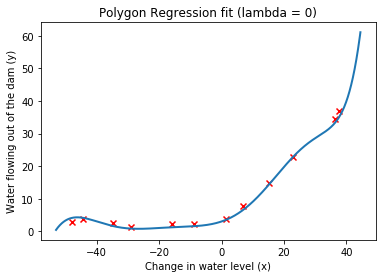

In [19]:
#For Lambda = 0
res_poly = trainLinearReg(xx_poly,Y,reg=0)
learning_theta = res_poly.x
#scatter plot of training data
plt.scatter(X, Y, marker="x", c="r" )
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

plotFit(X, min(X), max(X), learning_theta, d=8)
plt.title("Polygon Regression fit (lambda = 0)")



#### For lambda = 1 
#### This is best fit, have no high-bias and no high-variance

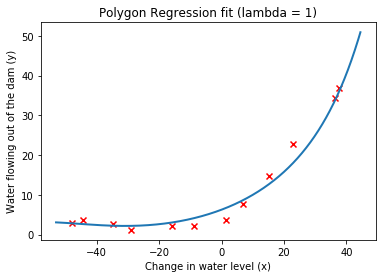

In [20]:
#lambda = 1
res_poly = trainLinearReg(xx_poly,Y,reg=1)
learning_theta = res_poly.x
#scatter plot of training data
plt.title("Polygon Regression fit (lambda = 1)")
plt.scatter(X, Y, marker="x", c="r" )
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

plotFit(X, min(X), max(X), learning_theta, d=8)
plt.show()

#### For lambda = 100 (Underfit)

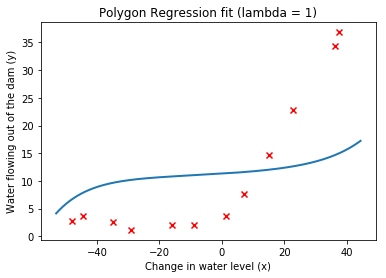

In [21]:
#lambda = 100
res_poly = trainLinearReg(xx_poly,Y,reg=100)
learning_theta = res_poly.x
#scatter plot of training data
plt.scatter(X, Y, marker="x", c="r" )
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')

plotFit(X, min(X), max(X), learning_theta, d=8)
plt.title("Polygon Regression fit (lambda = 1)")
plt.show()

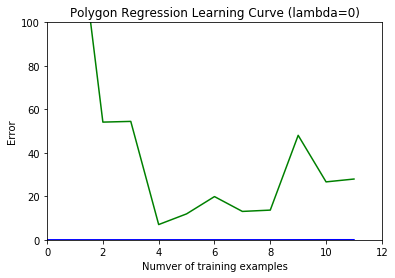

In [22]:
#Polygon learning curve for polygon regression
J_poly_train, J_poly_cv = learningCurve(xx_poly,Y,xx_poly_cv,Yval,reg=0)   #errors

m = len(J_poly_train)
plt.plot(range(m), J_poly_train, c="b", label = "Train")
plt.plot(range(m), J_poly_cv, c="g", label = "Cross Validation")
plt.title("Polygon Regression Learning Curve (lambda=0)")
plt.xlabel("Numver of training examples")
plt.ylabel("Error")
plt.xlim(0,12)
plt.ylim(0,100)
plt.show()

In [23]:
print("Cheers")

Cheers
